In [392]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.cross_validation import cross_val_score, cross_val_predict, train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from pymongo import *
from mpl_toolkits.basemap import Basemap
%matplotlib inline

In [393]:
# Import the spray data so that we can perform clustering analysis on it.
df = pd.read_csv('https://raw.githubusercontent.com/cl65610/west_nile/master/assets/spray.csv')

In [394]:
df.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [395]:
# Set our features for this clustering. 
X = df[['Longitude', 'Latitude']]

In [396]:
# After much tinkering, these parameters gave us what appeared to be an ideal number of groups
dbscn = DBSCAN(eps = .0049, min_samples = 80).fit(X)  
labels = dbscn.labels_

In [397]:
print 'This DBSCAN results in the creation of %d different labels.' % len(set(labels))

This DBSCAN results in the creation of 15 different labels.


In [343]:
print 'The Silhouette Coefficient for this model is: %0.3f.' % metrics.silhouette_score(X, labels)

The Silhouette Coefficient for this model is: 0.413.


In [398]:
# We will now treat these labels as a new feature of our data. Attaching them to our original dataframe will allow us to 
# plot them and visualize our accuracy.
labels_df = pd.DataFrame(labels.reshape(14835,1), columns = ['labels'])

In [399]:
# This merged dataframe is also the dataframe that we'll send up to sql to be joined on. 
merged_df = df.join(labels_df)
merged_df.head()

,Date,Time,Latitude,Longitude,labels
0,2011-08-29,6:56:58 PM,42.391623,-88.089163,0
1,2011-08-29,6:57:08 PM,42.391348,-88.089163,0
2,2011-08-29,6:57:18 PM,42.391022,-88.089157,0
3,2011-08-29,6:57:28 PM,42.390637,-88.089158,0
4,2011-08-29,6:57:38 PM,42.390410,-88.088858,0


In [400]:
svm = SVC()
X = merged_df[['Latitude', 'Longitude']]
y = merged_df['labels']
x_train, x_test, y_train, y_test = train_test_split(X, y)
svm.fit(x_train, y_train)
preds = svm.predict(x_test)
print 'The score for a RBF-SVM is %.4f' % svm.score(x_test, y_test)

The score for a RBF-SVM is 0.7641


In [12]:
knn = KNeighborsClassifier()
neigh = range(1,65)
param_dict = {'n_neighbors':neigh, 'weights':['uniform', 'distance']}
clf = GridSearchCV(knn, param_dict, cv=12, verbose = 1, n_jobs = -1)
clf.fit(X,y)
print 'The best score for our grid-searched KNN classifier is %.4f'% clf.best_score_

Fitting 12 folds for each of 128 candidates, totalling 1536 fits


[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 744 tasks      | elapsed:   12.3s


The best score for our grid-searched KNN classifier is 0.9642


[Parallel(n_jobs=-1)]: Done 1536 out of 1536 | elapsed:   28.7s finished


In [323]:
rf = RandomForestClassifier()
rf_fit = rf.fit(X,y)
print 'The score for our Random Forest model is %.5f.' % rf.score(X, y)
# After seeing the high score with this model, we saved the fit as the variable rf_fit. This way, we can use the fit to
# predict the spray zones for our train data.

The score for our Random Forest model is 0.97563.


In [401]:
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier()
etc_fit = etc.fit(X, y)
print 'The score for our Extra Trees model is %.5f.' % etc.score(X, y)

The score for our Extra Trees model is 1.00000.


In [402]:
# In order to test our accuracy, we will import our train data, apply the fit, and check visually to see how well our
# classifier performs.
train_df = pd.read_csv('https://raw.githubusercontent.com/cl65610/west_nile/master/assets/joined_pca.csv')

In [403]:
# As above, our features for this will be latitude and longitude. 
X2 = train_df[['Latitude', 'Longitude']]

In [404]:
# Here we predict what our train data spray zones will be and set those results equal to a dataframe that we can then join 
# onto our training data.
label_predicts = etc_fit.predict(X2)
xt_labels = pd.DataFrame(label_predicts, columns = ['xt_labels'])

In [405]:
labeled_df = train_df.join(xt_labels)

In [406]:
labeled_df.head()

,Unnamed: 0,Date,Species,Trap,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,day,...,PrecipTotal,Sunrise,Sunset,month_weather,day_weather,pca1,pca2,pca3,pca4,xt_labels
0,0,2007-05-29,2,1,41.954690,-87.800991,9,1,0,179,...,0.0,421.0,1917.0,5.0,179.0,-0.663872,3.033573,-1.434144,1.092123,7
1,1,2007-05-29,3,1,41.954690,-87.800991,9,1,0,179,...,0.0,421.0,1917.0,5.0,179.0,-0.663872,3.033573,-1.434144,1.092123,7
2,2,2007-05-29,3,6,41.994991,-87.769279,9,1,0,179,...,0.0,421.0,1917.0,5.0,179.0,-0.663872,3.033573,-1.434144,1.092123,2
3,3,2007-05-29,2,13,41.974089,-87.824812,8,1,0,179,...,0.0,421.0,1917.0,5.0,179.0,-0.663872,3.033573,-1.434144,1.092123,1
4,4,2007-05-29,3,13,41.974089,-87.824812,8,4,0,179,...,0.0,421.0,1917.0,5.0,179.0,-0.663872,3.033573,-1.434144,1.092123,1


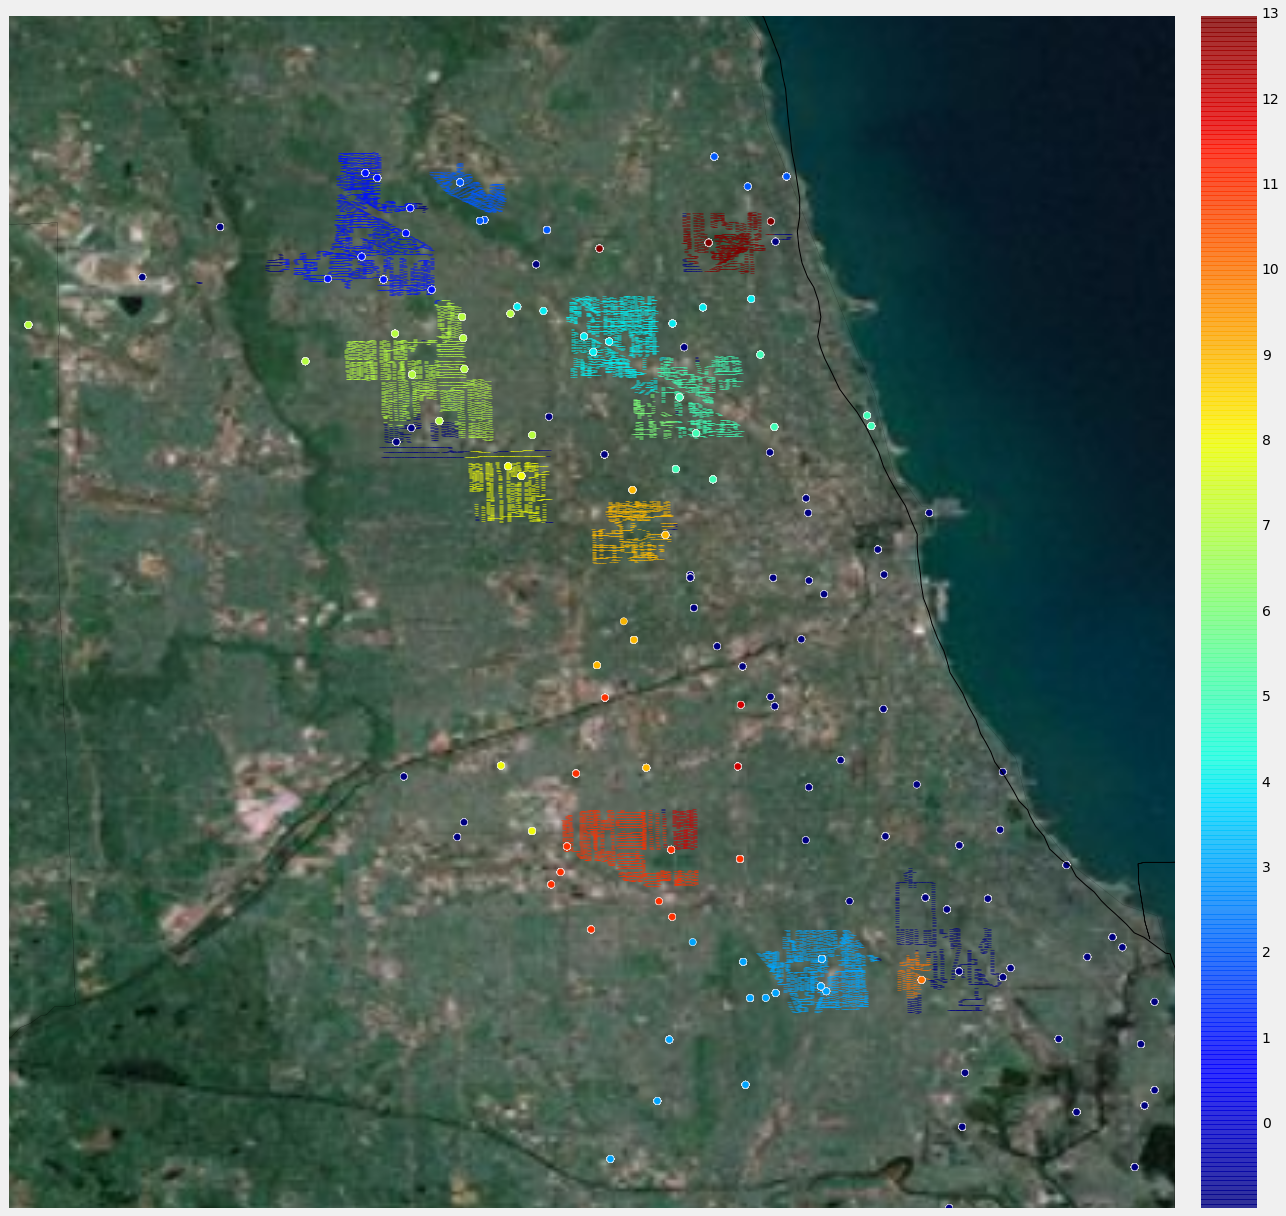

In [307]:
plt.figure(figsize=(20,20))
plt.style.use('fivethirtyeight')
m = Basemap(llcrnrlon=-87.938515,llcrnrlat=41.6443349,urcrnrlon=-87.524044,urcrnrlat=42.068155456,
                projection='cyl',resolution='f')
    # draw coastlines.
m.drawcoastlines()
m.drawstates()
m.drawrivers()
m.drawcounties()
m.drawcountries()
m.drawstates()
m.arcgisimage()

m.scatter(merged_df.Longitude, merged_df.Latitude, c=merged_df['labels'], s=15, marker='_')
m.scatter(labeled_df.Longitude, labeled_df.Latitude, c=labeled_df['rf_labels'], s=50, alpha = 0.8,marker = 'o')
m.colorbar(ticks=range(len(set(merged_df['labels']))))
plt.show()

Run a dbscan on our spray data to determine what the clusters of spraying are. After doing this, we have engineered a new feature for our spray data: the "spray zone." We can use this information to help us determine what spray zone a mosquito trap falls into. This process, unfortunately, is not quite as straightforward as we would have liked. In order to make this actionable we trained several classifiers on our spray data with the spray zone label set as the target. We then applied this model fit to our train data, thereby giving us a sense of which spray zone a trap fell into. This also importantly gave us a second feature that we could use to join our spray data onto our trap information. Unfortunately, there isn't a reliably easy way to join on two columns in pandas. The pythonic solution require creating a multiindex object that can be joined on.  To workaround this problem, we will send our two dataframes to a local sql database, join them there, and then pull down the properly joined results.


In [26]:
from sqlalchemy import create_engine
engine = create_engine('postgresql://codylaminack@localhost:5432/west_nile')

In [27]:
labeled_df.to_sql('joined_and_labeled', engine)
merged_df.to_sql('sprays_labeled', engine)

In [366]:
labeled_df.head()

,Unnamed: 0,Date,Species,Trap,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,day,...,PrecipTotal,Sunrise,Sunset,month_weather,day_weather,pca1,pca2,pca3,pca4,xt_labels
0,0,2007-05-29,2,1,41.954690,-87.800991,9,1,0,179,...,0.0,421.0,1917.0,5.0,179.0,-0.663872,3.033573,-1.434144,1.092123,7
1,1,2007-05-29,3,1,41.954690,-87.800991,9,1,0,179,...,0.0,421.0,1917.0,5.0,179.0,-0.663872,3.033573,-1.434144,1.092123,7
2,2,2007-05-29,3,6,41.994991,-87.769279,9,1,0,179,...,0.0,421.0,1917.0,5.0,179.0,-0.663872,3.033573,-1.434144,1.092123,2
3,3,2007-05-29,2,13,41.974089,-87.824812,8,1,0,179,...,0.0,421.0,1917.0,5.0,179.0,-0.663872,3.033573,-1.434144,1.092123,1
4,4,2007-05-29,3,13,41.974089,-87.824812,8,4,0,179,...,0.0,421.0,1917.0,5.0,179.0,-0.663872,3.033573,-1.434144,1.092123,1


In [407]:
from sklearn.preprocessing import scale
labeled_df.columns


Index([u'Unnamed: 0', u'Date', u'Species', u'Trap', u'Latitude', u'Longitude',
       u'AddressAccuracy', u'NumMosquitos', u'WnvPresent', u'day', u'month',
       u'year', u'Tmax', u'Tmin', u'Tavg', u'Depart', u'DewPoint',
       u'PrecipTotal', u'Sunrise', u'Sunset', u'month_weather', u'day_weather',
       u'pca1', u'pca2', u'pca3', u'pca4', u'xt_labels'],
      dtype='object')

In [409]:
features = ['Species', 'Trap', 'Latitude', 'Longitude', 'AddressAccuracy', 'day_weather', 'PrecipTotal', 
           'pca1', 'pca2', 'pca3', 'pca4', 'xt_labels', 'year']
X = labeled_df[features]

y = labeled_df.WnvPresent

In [369]:
from sklearn.ensemble import BaggingClassifier

In [370]:
rf.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [371]:
rf.score(X,y)

0.97725109461260229

In [372]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
cross_val_score(lr, X, y, cv=3).mean()

0.86529159232760033

In [373]:
knn = KNeighborsClassifier()
neigh = range(1,65)
param_dict = {'n_neighbors':neigh, 'weights':['uniform', 'distance']}
clf = GridSearchCV(knn, param_dict, cv=8, verbose = 1, n_jobs = -1)
clf.fit(X,y)
print clf.best_estimator_
print 'The best score for our grid-searched KNN classifier is %.4f'% clf.best_score_



Fitting 8 folds for each of 128 candidates, totalling 1024 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.4min


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=64, p=2,
           weights='uniform')
The best score for our grid-searched KNN classifier is 0.9430


[Parallel(n_jobs=-1)]: Done 1024 out of 1024 | elapsed:  1.9min finished


In [336]:
from sklearn.ensemble import VotingClassifier

voter = VotingClassifier(estimators = [('knn', knn),
                                      ('extra trees', xt_ideal), ('random forest', rf)],
                        voting = 'soft', weights = [1, 2, 1])

voter.fit(X, y)
print voter.score(X, y)



0.981058442795


In [377]:
svm = SVC()
x_train, x_test, y_train, y_test = train_test_split(X, y)
svm.fit(x_train, y_train)
preds = svm.predict(x_test)
print 'The score for a RBF-SVM is %.4f' % svm.score(x_test, y_test)

The score for a RBF-SVM is 0.9486


In [378]:
svc_params = {'kernel':['rbf', 'linear'],
              'C':[.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0],
             'degree':[1, 2, 3, 4, 5]}
svc = SVC()

svc_gscv = GridSearchCV(svc, param_grid = svc_params, cv = 3, n_jobs = -1, verbose = 1)
svc_fit = svc_gscv.fit(X, y)
print svc_fit.best_score_
print svc_fit.best_estimator_
print svc_fit.best_params_

Fitting 3 folds for each of 70 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   30.6s finished


0.947553778793
SVC(C=0.8, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=1, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
{'kernel': 'linear', 'C': 0.8, 'degree': 1}


In [379]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB

In [380]:
gnb = GaussianNB()
gnb.fit(X,y)

GaussianNB()

In [381]:
gnb.score(X,y)

0.93070626308775939

In [55]:
from sklearn.grid_search import GridSearchCV
etc_params = {'n_estimators':range(50, 500, 25), 'criterion':['gini', 'entropy'],
             'max_features':['sqrt', 'log2', .25, .5, .75, 1], 'min_samples_split':[2, 3, 5, 10, 20],
             'min_samples_leaf':[1, 2, 3]}

etc_params2 = {'n_estimators':range(50, 100, 2), 'max_depth':[2, 3, 4, 5, 6, 7, 8]}

from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
xt = ExtraTreesClassifier(oob_score = True, bootstrap = True)

xt_gs = GridSearchCV(xt, param_grid = etc_params2, verbose = 1, n_jobs = -1, cv = None)
xt_fit = xt_gs.fit(X, y)

print xt_fit.best_score_
print xt_fit.best_estimator_
print xt_fit.best_params_
# xt.fit(X,y)
# xt.score(X,y)

Fitting 3 folds for each of 175 candidates, totalling 525 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done 525 out of 525 | elapsed:   57.1s finished


0.947553778793
ExtraTreesClassifier(bootstrap=True, class_weight=None, criterion='gini',
           max_depth=2, max_features='auto', max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)
{'n_estimators': 50, 'max_depth': 2}


In [410]:
xt_ideal = ExtraTreesClassifier()
xt_fit = xt_ideal.fit(X, y)
print xt_ideal.score(X, y)
print xt_ideal.get_params
print xt_ideal.feature_importances_

0.981058442795
<bound method ExtraTreesClassifier.get_params of ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)>
[ 0.18216347  0.14528014  0.15128907  0.15845244  0.05237309  0.04335836
  0.02176023  0.03060622  0.03877971  0.03064702  0.0283781   0.0857209
  0.03119128]


In [383]:
import numpy as np
predicts = xt_ideal.predict_proba(X)
pred_proba = predicts[:,1]
print len(predicts)
print len(y_test)
pred_proba

10506
2627


array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

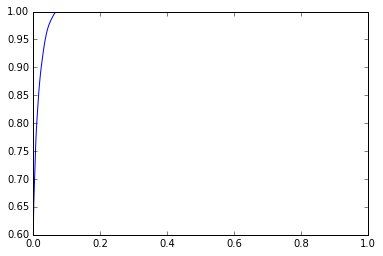

0.993873155151


In [384]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = metrics.roc_curve(y, pred_proba)

plt.plot(fpr, tpr, label = 'Extra Trees')
plt.show()

auc = metrics.auc(fpr, tpr)
print auc

In [90]:
from sklearn.metrics import classification_report, confusion_matrix
cr = classification_report(y_test, predicts)
cm = confusion_matrix(y_test,predicts)

In [91]:
print cr
print cm

             precision    recall  f1-score   support

          0       0.98      1.00      0.99      2482
          1       0.96      0.70      0.81       145

avg / total       0.98      0.98      0.98      2627

[[2478    4]
 [  44  101]]


In [93]:
gbc = GradientBoostingClassifier()
gbc.fit(X,y)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [94]:
gbc.score(X,y)

0.9483152484294689

# Test Dataframe Work

In [411]:
final_joined_pca = pd.read_csv('/Users/TerryONeill/west_nile/west_nile/assets/final_joined_pca.csv')
print final_joined_pca.shape
final_joined_pca.head()

(116293, 24)


,Unnamed: 0,Date,Species,Trap,Latitude,Longitude,AddressAccuracy,day,month,year,...,DewPoint,PrecipTotal,Sunrise,Sunset,month_weather,day_weather,pca1,pca2,pca3,pca4
0,0,2008-06-11,2,1,41.95469,-87.800991,9,191,6,2008,...,55.5,0.0,416.0,1926.0,6.0,191.0,-1.514379,-1.779891,-0.967131,0.524445
1,1,2008-06-11,3,1,41.95469,-87.800991,9,191,6,2008,...,55.5,0.0,416.0,1926.0,6.0,191.0,-1.514379,-1.779891,-0.967131,0.524445
2,2,2008-06-11,1,1,41.95469,-87.800991,9,191,6,2008,...,55.5,0.0,416.0,1926.0,6.0,191.0,-1.514379,-1.779891,-0.967131,0.524445
3,3,2008-06-11,4,1,41.95469,-87.800991,9,191,6,2008,...,55.5,0.0,416.0,1926.0,6.0,191.0,-1.514379,-1.779891,-0.967131,0.524445
4,4,2008-06-11,6,1,41.95469,-87.800991,9,191,6,2008,...,55.5,0.0,416.0,1926.0,6.0,191.0,-1.514379,-1.779891,-0.967131,0.524445


In [412]:
## need to drop unnamed column that forms from the index of the original dataframe
final_joined_pca = final_joined_pca.drop('Unnamed: 0', axis = 1)
print final_joined_pca.shape
final_joined_pca.head()

(116293, 23)


,Date,Species,Trap,Latitude,Longitude,AddressAccuracy,day,month,year,Tmax,...,DewPoint,PrecipTotal,Sunrise,Sunset,month_weather,day_weather,pca1,pca2,pca3,pca4
0,2008-06-11,2,1,41.95469,-87.800991,9,191,6,2008,86.0,...,55.5,0.0,416.0,1926.0,6.0,191.0,-1.514379,-1.779891,-0.967131,0.524445
1,2008-06-11,3,1,41.95469,-87.800991,9,191,6,2008,86.0,...,55.5,0.0,416.0,1926.0,6.0,191.0,-1.514379,-1.779891,-0.967131,0.524445
2,2008-06-11,1,1,41.95469,-87.800991,9,191,6,2008,86.0,...,55.5,0.0,416.0,1926.0,6.0,191.0,-1.514379,-1.779891,-0.967131,0.524445
3,2008-06-11,4,1,41.95469,-87.800991,9,191,6,2008,86.0,...,55.5,0.0,416.0,1926.0,6.0,191.0,-1.514379,-1.779891,-0.967131,0.524445
4,2008-06-11,6,1,41.95469,-87.800991,9,191,6,2008,86.0,...,55.5,0.0,416.0,1926.0,6.0,191.0,-1.514379,-1.779891,-0.967131,0.524445


In [413]:
# As above, our features for this will be latitude and longitude. 
X2 = final_joined_pca[['Latitude', 'Longitude']]

In [414]:
# Here we predict what our test data spray zones will be and set those results equal to a dataframe that we can then join 
# onto our joined_pca data.
label_predicts = etc_fit.predict(X2)
xt_labels = pd.DataFrame(label_predicts, columns = ['xt_labels'])
print xt_labels.shape
xt_labels.head()

(116293, 1)


,xt_labels
0,7
1,7
2,7
3,7
4,7


In [415]:
labeled_df = final_joined_pca.join(xt_labels)

In [416]:
print labeled_df.shape
labeled_df.head()

(116293, 24)


,Date,Species,Trap,Latitude,Longitude,AddressAccuracy,day,month,year,Tmax,...,PrecipTotal,Sunrise,Sunset,month_weather,day_weather,pca1,pca2,pca3,pca4,xt_labels
0,2008-06-11,2,1,41.95469,-87.800991,9,191,6,2008,86.0,...,0.0,416.0,1926.0,6.0,191.0,-1.514379,-1.779891,-0.967131,0.524445,7
1,2008-06-11,3,1,41.95469,-87.800991,9,191,6,2008,86.0,...,0.0,416.0,1926.0,6.0,191.0,-1.514379,-1.779891,-0.967131,0.524445,7
2,2008-06-11,1,1,41.95469,-87.800991,9,191,6,2008,86.0,...,0.0,416.0,1926.0,6.0,191.0,-1.514379,-1.779891,-0.967131,0.524445,7
3,2008-06-11,4,1,41.95469,-87.800991,9,191,6,2008,86.0,...,0.0,416.0,1926.0,6.0,191.0,-1.514379,-1.779891,-0.967131,0.524445,7
4,2008-06-11,6,1,41.95469,-87.800991,9,191,6,2008,86.0,...,0.0,416.0,1926.0,6.0,191.0,-1.514379,-1.779891,-0.967131,0.524445,7


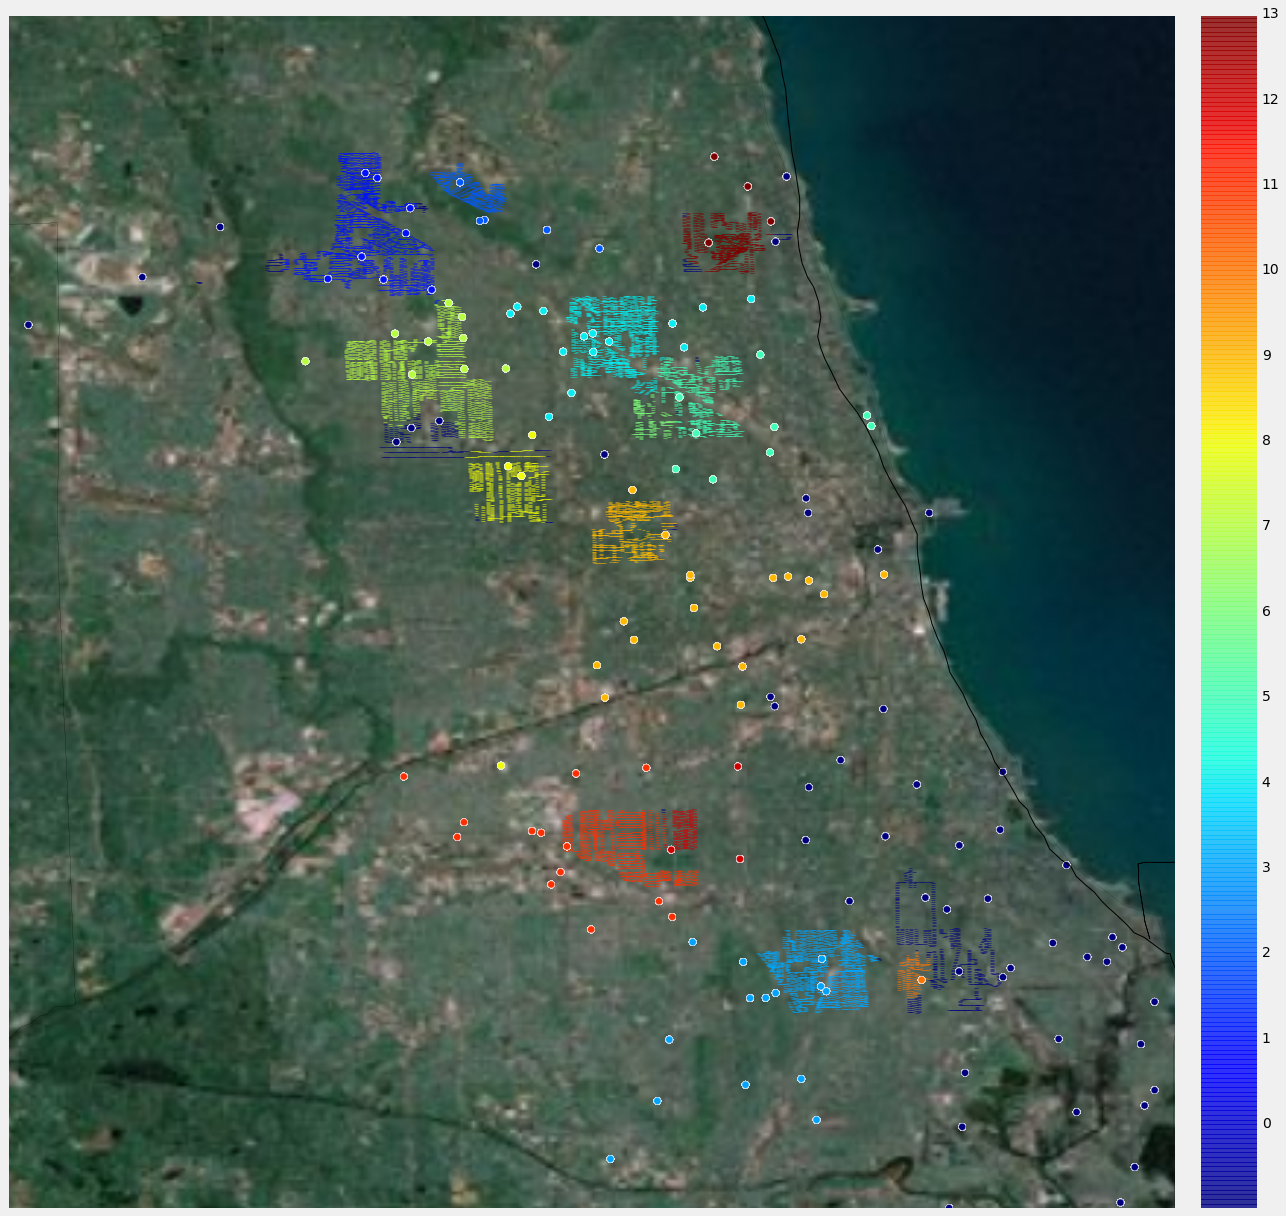

In [391]:
plt.figure(figsize=(20,20))
plt.style.use('fivethirtyeight')
m = Basemap(llcrnrlon=-87.938515,llcrnrlat=41.6443349,urcrnrlon=-87.524044,urcrnrlat=42.068155456,
                projection='cyl',resolution='f')
    # draw coastlines.
m.drawcoastlines()
m.drawstates()
m.drawrivers()
m.drawcounties()
m.drawcountries()
m.drawstates()
m.arcgisimage()

m.scatter(merged_df.Longitude, merged_df.Latitude, c=merged_df['labels'], s=15, marker='_')
m.scatter(labeled_df.Longitude, labeled_df.Latitude, c=labeled_df['xt_labels'], s=50, alpha = 0.8,marker = 'o')
m.colorbar(ticks=range(len(set(merged_df['labels']))))
plt.show()

In [417]:
features = ['Species', 'Trap', 'Latitude', 'Longitude', 'AddressAccuracy', 'day_weather', 'PrecipTotal', 
           'pca1', 'pca2', 'pca3', 'pca4', 'xt_labels', 'year']
X = labeled_df[features]


In [418]:
test_pred = xt_fit.predict(X)

In [420]:
test_pred_df = pd.DataFrame(test_pred, columns = ['test_predictions'])
test_pred_df.head()

,test_predictions
0,0
1,0
2,0
3,0
4,0


In [421]:
test_pred_df.test_predictions.value_counts()

0    116151
1       142
Name: test_predictions, dtype: int64

In [422]:
test_pred_df.to_csv('test_data_predictions')